In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [5]:
num_classes = 10
input_shape = (28, 28, 1)
image_size = 32  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [512, 128]  # Size of the dense layers of the final classifier

In [6]:
preprocessing = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="preprocessing",
)
# Compute the mean and the variance of the training data for normalization.
preprocessing.layers[0].adapt(x_train)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 16
The shape of patches:  (1, 64, 16)


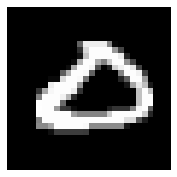

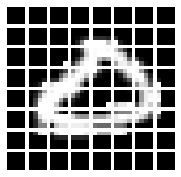

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"), cmap='gray')
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print("The shape of patches: ", patches.shape)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(3, 3))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

In [15]:
class PatchEncoder(layers.Layer):
    """
    The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.
    """
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [16]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    preprocessed = preprocessing(inputs) # 입력 이미지에 대한 전처리 수행, 즉 표준화와 resize
    patches = Patches(patch_size)(preprocessed) # 이미지를 패치 단위로 분할
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # 각 패치에 대한 임베딩 벡터 생성

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
model = create_vit_classifier()

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 preprocessing (Sequential)     (None, 32, 32, 1)    3           ['input_2[0][0]']                
                                                                                                  
 patches_3 (Patches)            (None, None, 16)     0           ['preprocessing[1][0]']          
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 64, 64)      5184        ['patches_3[0][0]']              
                                                                                            

In [19]:
from tensorflow.keras.utils import to_categorical 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [20]:
model.compile(
    optimizer=tf.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_tr1"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [23]:
history = model.fit(x_train,y_train_one_hot, batch_size=128, epochs=10,
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
422/422 [==============================] - 179s 425ms/step - loss: 1.2197 - accuracy: 0.5925 - val_loss: 0.3206 - val_accuracy: 0.9138
Epoch 2/10
422/422 [==============================] - 186s 440ms/step - loss: 0.6136 - accuracy: 0.8069 - val_loss: 0.2089 - val_accuracy: 0.9428
Epoch 3/10
422/422 [==============================] - 190s 449ms/step - loss: 0.4486 - accuracy: 0.8645 - val_loss: 0.1523 - val_accuracy: 0.9557
Epoch 4/10
422/422 [==============================] - 193s 457ms/step - loss: 0.3529 - accuracy: 0.8945 - val_loss: 0.1346 - val_accuracy: 0.9657
Epoch 5/10
422/422 [==============================] - 192s 454ms/step - loss: 0.2998 - accuracy: 0.9137 - val_loss: 0.1088 - val_accuracy: 0.9682
Epoch 6/10
422/422 [==============================] - 188s 445ms/step - loss: 0.2605 - accuracy: 0.9241 - val_loss: 0.0910 - val_accuracy: 0.9723
Epoch 7/10
422/422 [==============================] - 180s 426ms/step - loss: 0.2282 - accuracy: 0.9346 - val_loss: 0.0800 -

In [24]:
model.load_weights(checkpoint_filepath)

In [25]:
model.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 12s 37ms/step - loss: 0.0713 - accuracy: 0.9788


[0.07130373269319534, 0.9787999987602234]